# Расчет LTV

### Задача: 

Вы работаете в небольшой компании, где есть маркетолог, но нет аналитика. Маркетолог просит вас определить LTV пользователя: это поможет определить затраты на привлечение новых клиентов.
Вы посмотрели логи, там есть два набора данных: визиты пользователей на сервис и данные по покупкам. У каждого визита есть источник, а также устройство, с которого заходил пользователь. 
1. Чему на ваш взгляд равен LTV пользователей? 
2. Есть ли у вас рекомендации по его улучшению?


<div id='step0'/>

### Навигация:

- [Описание данных](#step1)
- [Импорт данных](#step2); 
- [Предобработка данных](#step3);
- [Когортный анализ](#step4);
- [Общий вывод](#step5).

<div id='step1'/>

## Описание данных:

- `start_dt` — дата старта визита,
- `start_ts` — дата и время старта визита,
- `end_ts` — дата окончания визита,
- `uid` — идентификатор пользователя,
- `source_id` — id источника визита,
- `device` — устройство,
- `buy_ts` — дата и время покупки,
- `revenue` — доход в y.e.

[В начало](#step0)

<div id='step2'/>

## Импорт данных:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
p = pd.read_csv('purchases.csv', sep='\t', parse_dates=[0],infer_datetime_format=True)

[В начало](#step0)

<div id='step3'/>

## Предобработка данных:

In [3]:
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   75716 non-null  datetime64[ns]
 1   uid      75716 non-null  int64         
 2   revenue  75716 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [4]:
p.head()

,buy_ts,uid,revenue
0,2016-07-23 19:13:54,3492372810,"1,47"
1,2016-11-06 02:48:27,1564753091,"1,11"
2,2017-01-31 20:32:42,1385616391,"16,8"
3,2017-01-11 10:52:11,2636761148,11
4,2016-11-25 18:57:09,2945629974,"4,89"


In [5]:
p['revenue'] = p['revenue'].str.replace(",", ".")
p['revenue'] = p['revenue'].astype(float)
p.head()

,buy_ts,uid,revenue
0,2016-07-23 19:13:54,3492372810,1.47
1,2016-11-06 02:48:27,1564753091,1.11
2,2017-01-31 20:32:42,1385616391,16.80
3,2017-01-11 10:52:11,2636761148,11.00
4,2016-11-25 18:57:09,2945629974,4.89


In [6]:
v = pd.read_csv('visits.csv', sep='\t', parse_dates=[1, 3, 4],infer_datetime_format=True)

In [7]:
v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     720679 non-null  object        
 1   end_ts     720679 non-null  datetime64[ns]
 2   source_id  720679 non-null  int64         
 3   start_dt   720679 non-null  datetime64[ns]
 4   start_ts   720679 non-null  datetime64[ns]
 5   uid        720679 non-null  int64         
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 33.0+ MB


In [8]:
v.head()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30 11:04:17,2,2016-11-30,2016-11-30 10:53:49,3758486201
1,desktop,2016-11-10 23:16:57,4,2016-11-10,2016-11-10 23:08:04,2933941628
2,desktop,2016-10-19 18:51:56,1,2016-10-19,2016-10-19 18:48:16,1465872791
3,desktop,2017-01-12 20:51:55,9,2017-01-12,2017-01-12 20:50:10,2751875787
4,touch,2016-07-23 19:17:19,4,2016-07-23,2016-07-23 19:10:57,3492372810


Я убедилась, что в данных нет пропусков и привела данные к соотвествующим типам. Расчета метрики LTV буду делать с помощью когортного анализа. 

[В начало](#step0)

<div id='step4'/>

## Когортный анализ

Для этого используем таблицу `purchase`. Найдем дату первой покупки каждого покупателя; вычислим число новых покупателей за каждую дату; добавим дату первой покупки в таблицу с заказами; сгруппируем таблицу и посчитаем выручку.

In [9]:
p.head()

,buy_ts,uid,revenue
0,2016-07-23 19:13:54,3492372810,1.47
1,2016-11-06 02:48:27,1564753091,1.11
2,2017-01-31 20:32:42,1385616391,16.80
3,2017-01-11 10:52:11,2636761148,11.00
4,2016-11-25 18:57:09,2945629974,4.89


In [10]:
p['order_month'] = p['buy_ts'].astype('datetime64[M]')

#выделим для каждого пользователя дату его первого заказа:
first_orders = p.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

#посчитаем сколько пользователей сделали первый заказ в каждом месяце:
n_buyers = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
n_buyers.columns = ['first_order_month', 'n_buyers']

#создадим когорты, для этого добавим в таблицу месяц первого заказа и сгруппируем ее помесячно:
p_new = pd.merge(p,first_orders, on='uid')
ltv_cohorts = p_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#cоединим с количеством пользователей и выделим срок жизни когорты:
ltv_report = pd.merge(n_buyers, ltv_cohorts, on='first_order_month')
ltv_report['cohort_lifetime'] = (ltv_report['order_month'] - ltv_report['first_order_month']) / np.timedelta64(1, 'M')
ltv_report['cohort_lifetime'] = ltv_report['cohort_lifetime'].round().astype('int')
ltv_report.head()

,first_order_month,n_buyers,order_month,revenue,cohort_lifetime
0,2016-06-01,3509,2016-06-01,15864.99,0
1,2016-06-01,3509,2016-07-01,1710.54,1
2,2016-06-01,3509,2016-08-01,1348.97,2
3,2016-06-01,3509,2016-09-01,3782.30,3
4,2016-06-01,3509,2016-10-01,5225.50,4


Наконец, найдём LTV. Разделим прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Составим сводную таблицу:

In [11]:
ltv_report['ltv'] = ltv_report['revenue'] / ltv_report['n_buyers']
ltv_report['first_order_month'] = ltv_report['first_order_month'].dt.strftime('%Y-%m-%d')

ltv_report_output = ltv_report.pivot_table(index='first_order_month', columns='cohort_lifetime', 
                            values='ltv', aggfunc='mean')
ltv_report_output.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2016-06-01,4.52,5.01,5.39,6.47,7.96,9.18,10.23,11.15,12,12.89,13.7,14.08
2016-07-01,5.78,6.04,6.58,6.91,7.06,7.18,7.28,7.42,7.58,7.71,7.83,
2016-08-01,5.28,6.28,6.72,7.06,7.5,7.85,8.11,8.42,8.71,8.85,,
2016-09-01,5.29,6.23,6.68,9.31,9.59,10.03,10.6,10.77,10.91,,,
2016-10-01,4.72,5.18,5.34,5.47,5.58,5.69,5.78,5.88,,,,
2016-11-01,5.19,5.51,5.7,5.97,6.1,6.16,6.25,,,,,
2016-12-01,4.51,4.72,5.37,6.1,6.31,6.54,,,,,,
2017-01-01,4.05,4.31,4.56,4.68,4.73,,,,,,,
2017-02-01,4.10,4.31,4.38,4.45,,,,,,,,


Добавим ограничение для когорт, младше 6 месяцев, то есть всех, начиная с января 2018г и ограничим жизненный цикл периодом в полгода.

In [12]:
ltv_6_report = ltv_report.loc[(ltv_report['first_order_month'] < '2017-01-01') & (ltv_report['cohort_lifetime'] < 6)]

ltv_6_report_output = ltv_6_report.pivot_table(index='first_order_month', columns='cohort_lifetime', 
                            values='ltv', aggfunc='mean')
ltv_6_report_output.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5
first_order_month,,,,,,
2016-06-01,4.52,5.01,5.39,6.47,7.96,9.18
2016-07-01,5.78,6.04,6.58,6.91,7.06,7.18
2016-08-01,5.28,6.28,6.72,7.06,7.50,7.85
2016-09-01,5.29,6.23,6.68,9.31,9.59,10.03
2016-10-01,4.72,5.18,5.34,5.47,5.58,5.69
2016-11-01,5.19,5.51,5.70,5.97,6.10,6.16
2016-12-01,4.51,4.72,5.37,6.10,6.31,6.54


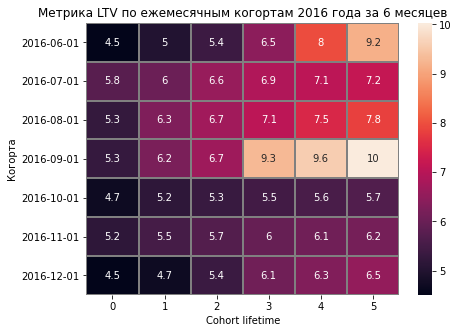

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(ltv_6_report_output.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray')
plt.title('Метрика LTV по ежемесячным когортам 2016 года за 6 месяцев')
plt.xlabel('Cohort lifetime')
plt.ylabel('Когорта');

Начальные значения метрики - 4,5 - 5,8 ед. Минимальное значение LTV в конце обозначенного жизненного цикла - 5,7, максимальное - 11. Самые высокие занчения 10 и 9,2 ед. у сентябрьской и июньской когорты 2016. Хорошие показатели в августе и июле (7,8 и 7,2). Поздние когорты не вырастают за 6,5 ед.  Среднее значение LTV по семи когортам 7,5 ед. 

Объединим таблицы, чтобы посчитать значение LTV:

In [14]:
v['visit_month'] = v['start_dt'].astype('datetime64[M]')
first_device = v.groupby('uid').agg({'visit_month': 'min', 'device': 'first', 'source_id':'first'}).reset_index()
first_device.columns = ['uid','first_visit_month', 'device', 'source_id']
first_device.head()

,uid,first_visit_month,device,source_id
0,4245,2016-11-01,desktop,5
1,5097,2017-02-01,desktop,3
2,8896,2017-01-01,desktop,3
3,21017,2016-06-01,desktop,5
4,30696,2016-11-01,desktop,3


In [15]:
df = pd.merge(p, first_device, how = 'left', on = 'uid')
df.head()

,buy_ts,uid,revenue,order_month,first_visit_month,device,source_id
0,2016-07-23 19:13:54,3492372810,1.47,2016-07-01,2016-07-01,touch,4
1,2016-11-06 02:48:27,1564753091,1.11,2016-11-01,2016-11-01,desktop,5
2,2017-01-31 20:32:42,1385616391,16.80,2017-01-01,2017-01-01,desktop,3
3,2017-01-11 10:52:11,2636761148,11.00,2017-01-01,2016-06-01,desktop,1
4,2016-11-25 18:57:09,2945629974,4.89,2016-11-01,2016-11-01,desktop,4


In [16]:
desktop_users = df[df['device'] == 'desktop'
                            ].groupby('first_visit_month').agg({'uid': 'nunique'}).reset_index()
desktop_users.columns = ['first_visit_month', 'desktop_users']
desktop_users

(desktop_users
 .style
 .set_caption('Количество новых пользователей `desktop` за месяц')
 .background_gradient(cmap='Blues')
)

,first_visit_month,desktop_users
0,2016-06-01 00:00:00,4139
1,2016-07-01 00:00:00,3107
2,2016-08-01 00:00:00,2273
3,2016-09-01 00:00:00,3787
4,2016-10-01 00:00:00,5902
5,2016-11-01 00:00:00,5083
6,2016-12-01 00:00:00,4918
7,2017-01-01 00:00:00,3655
8,2017-02-01 00:00:00,3740
9,2017-03-01 00:00:00,3352


In [17]:
desktop_cohorts = df.query('device == "desktop"')\
                    .groupby(['first_visit_month','order_month'])\
                    .agg({'revenue': 'sum'})\
                    .reset_index()
desktop = pd.merge(desktop_cohorts, desktop_users, on='first_visit_month')
desktop['cohort_lifetime'] = (desktop['order_month'] - desktop['first_visit_month']) / np.timedelta64(1, 'M')
desktop['cohort_lifetime'] = desktop['cohort_lifetime'].round().astype('int')
desktop['first_visit_month'] = desktop['first_visit_month'].dt.strftime('%Y-%m-%d')
desktop['ltv'] = desktop['revenue'] / desktop['desktop_users']
desktop_6_ltv = desktop.loc[(desktop['first_visit_month'] < '2017-01-01') & (desktop['cohort_lifetime'] < 6)]

desktop_6_ltv = desktop_6_ltv.pivot_table(index='first_visit_month', columns='cohort_lifetime', 
                            values='ltv', aggfunc='mean')
desktop_6_ltv = desktop_6_ltv.cumsum(axis=1).fillna('').round(2)
desktop_6_ltv

cohort_lifetime,0,1,2,3,4,5
first_visit_month,,,,,,
2016-06-01,3.26,4.11,4.64,6.42,8.21,9.64
2016-07-01,4.03,4.40,4.91,5.29,5.63,5.95
2016-08-01,3.64,4.19,4.77,5.23,5.71,6.01
2016-09-01,3.83,4.66,5.15,7.90,8.19,8.71
2016-10-01,3.77,4.39,4.64,4.85,5.06,5.24
2016-11-01,3.92,4.50,4.76,5.11,5.32,5.49
2016-12-01,4.06,4.44,5.31,6.33,6.64,6.99


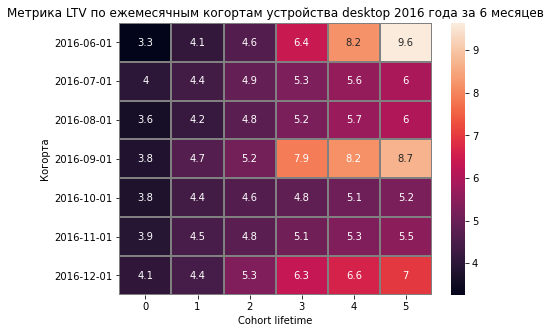

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(desktop_6_ltv, annot=True, linewidths=1, linecolor='gray')
plt.title('Метрика LTV по ежемесячным когортам устройства desktop 2016 года за 6 месяцев')
plt.xlabel('Cohort lifetime')
plt.ylabel('Когорта');

Начальные значения метрики - 3,3 - 4,1 ед. Минимальное значение LTV `desktop` в конце обозначенного жизненного цикла - 5,2, максимальное - 9,6. Мы видим, что распределение значения LTV похожи на общие трендам метрики. Самые высокие занченияу июньской и сентябрьской когорты (9,6 и 8,7). На третьем месте декабрь - 7 ед. Летние когорты в целом лучше себя показывают, чем осенние. Среднее значение LTV по семи когортам 6,9 ед. 

In [19]:
touch_users = df[df['device'] == 'touch'
                            ].groupby('first_visit_month').agg({'uid': 'nunique'}).reset_index()
touch_users.columns = ['first_visit_month', 'touch_users']
touch_users

(touch_users
 .style
 .set_caption('Количество новых пользователей `touch` за месяц')
 .background_gradient(cmap='Blues')
)

,first_visit_month,touch_users
0,2016-06-01 00:00:00,934
1,2016-07-01 00:00:00,805
2,2016-08-01 00:00:00,547
3,2016-09-01 00:00:00,970
4,2016-10-01 00:00:00,1358
5,2016-11-01 00:00:00,1179
6,2016-12-01 00:00:00,1136
7,2017-01-01 00:00:00,970
8,2017-02-01 00:00:00,953
9,2017-03-01 00:00:00,790


In [20]:
touch_cohorts = df.query('device == "touch"')\
                    .groupby(['first_visit_month','order_month'])\
                    .agg({'revenue': 'sum'})\
                    .reset_index()
touch = pd.merge(touch_cohorts, touch_users, on='first_visit_month')
touch['cohort_lifetime'] = (touch['order_month'] - touch['first_visit_month']) / np.timedelta64(1, 'M')
touch['cohort_lifetime'] = touch['cohort_lifetime'].round().astype('int')
touch['first_visit_month'] = touch['first_visit_month'].dt.strftime('%Y-%m-%d')
touch['ltv'] = touch['revenue'] / touch['touch_users']
touch_6_ltv = touch.loc[(touch['first_visit_month'] < '2017-01-01') & (touch['cohort_lifetime'] < 6)]

touch_6_ltv = touch_6_ltv.pivot_table(index='first_visit_month', columns='cohort_lifetime', 
                            values='ltv', aggfunc='mean')
touch_6_ltv = touch_6_ltv.cumsum(axis=1).fillna('').round(2)
touch_6_ltv

cohort_lifetime,0,1,2,3,4,5
first_visit_month,,,,,,
2016-06-01,2.53,3.14,3.44,4.13,4.99,5.73
2016-07-01,3.62,4.02,4.32,4.60,4.86,5.02
2016-08-01,3.15,4.36,4.89,5.38,5.70,6.11
2016-09-01,3.01,4.92,5.73,5.98,6.19,6.35
2016-10-01,3.20,4.30,4.66,4.84,5.05,5.43
2016-11-01,4.28,4.94,5.21,5.32,5.55,5.65
2016-12-01,3.26,3.64,3.87,4.22,4.31,4.47


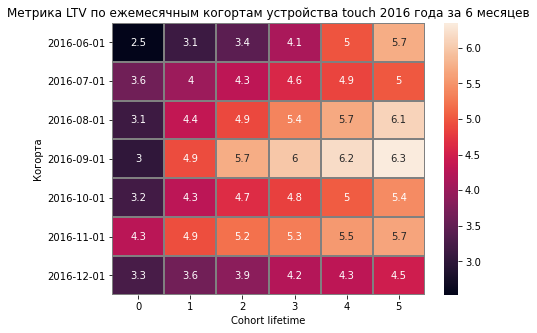

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(touch_6_ltv, annot=True, linewidths=1, linecolor='gray')
plt.title('Метрика LTV по ежемесячным когортам устройства touch 2016 года за 6 месяцев')
plt.xlabel('Cohort lifetime')
plt.ylabel('Когорта');

Начальные значения метрики - 2,5 - 4,3 ед. Минимальное значение LTV `touch` в конце обозначенного жизненного цикла - 4,5, максимальное - 6,3. Мы видим, что по сравнению с предыдущими графиками, когорты растут более равномерно. Сразвнительно высокие финальные показатели LTV у августовской (6,1) и ноябрьской (5,7) когорт. 

Среднее значение LTV по семи когортам 5,5 ед. 

Можно сделать вывод, что пользователи, которые впервые посетили сайт с устройства `desktop` приносят больше денег в июньской, сентябрьской и декабрьской когортах. 

Далее проанализируем рекламные источники:

In [22]:
sources = df['source_id'].sort_values().drop_duplicates().tolist()
sources

[1, 2, 3, 4, 5, 7, 9, 10]

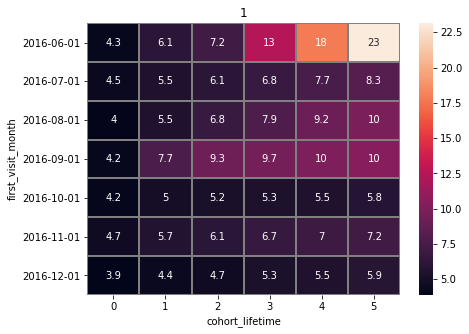

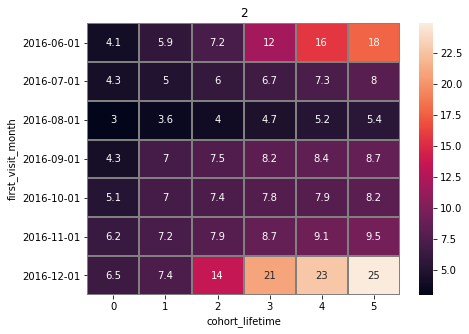

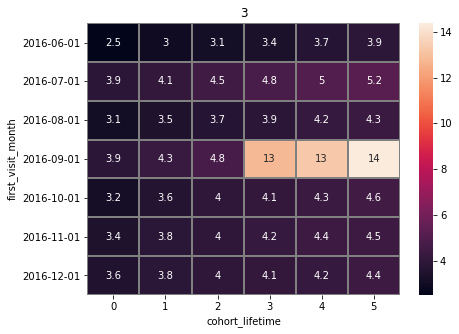

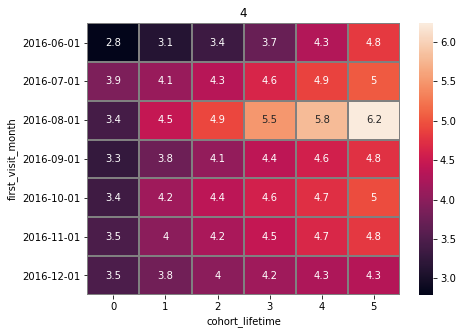

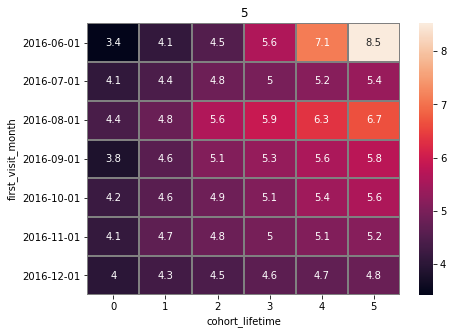

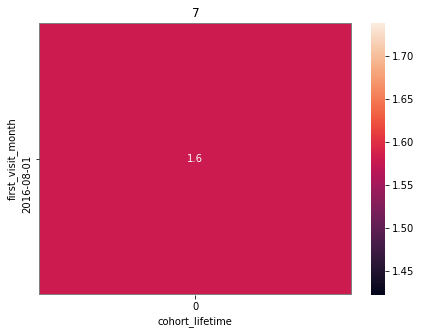

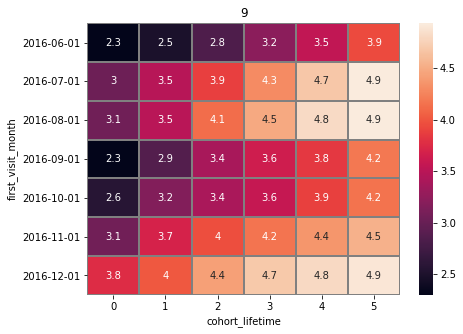

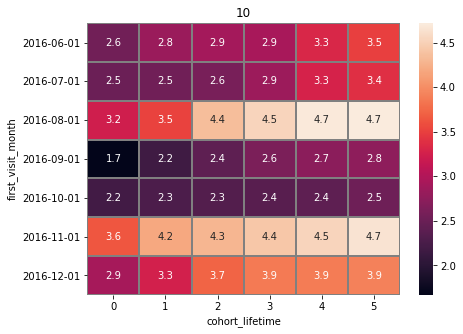

In [23]:
for i in [1, 2, 3, 4, 5, 7, 9, 10]:
    s_users = df.loc[df['source_id'] == i
                        ].groupby('first_visit_month'
                                 ).agg({'uid': 'nunique'}).reset_index()
    s_users.columns = ['first_visit_month', 's_users']

    s_cohorts = df[df['source_id'] == i]\
                      .groupby(['first_visit_month','order_month'])\
                      .agg({'revenue': 'sum'})\
                      .reset_index()
    s_report = pd.merge(s_cohorts, s_users, on='first_visit_month')
    s_report['cohort_lifetime'] = (s_report['order_month'] - s_report['first_visit_month']) / np.timedelta64(1, 'M')
    s_report['cohort_lifetime'] = s_report['cohort_lifetime'].round().astype('int')
    s_report['first_visit_month'] = s_report['first_visit_month'].dt.strftime('%Y-%m-%d')
    s_report['ltv'] = s_report['revenue'] / s_report['s_users']
    s_report_6 = s_report.loc[(s_report['first_visit_month'] < '2017-01-01') & (s_report['cohort_lifetime'] < 6)]

    s_report_6_ltv = s_report_6.pivot_table(index='first_visit_month', 
                                                columns='cohort_lifetime', 
                                                values='ltv', 
                                                aggfunc='mean')
    s_report_6_ltv = s_report_6_ltv.cumsum(axis=1).round(2)
    plt.figure(figsize=(7, 5))
    plt.title(i)
    sns.heatmap(s_report_6_ltv, annot=True, linewidths=1, linecolor='gray');

Полученнные итоговые знаенчия LTV будем сравнивать со средним значением метрики - 7,5 ед. Судя по полученным графикам, самых платежеспособных пользователей привлекли по 1 и 2 источникам. 3 источник дал хоршоий результат только в сентябрьской когорте, остальные когорты  - ниже среднего. 

Но если посмотреть на динамику роста метрики на графике, можно отметить интересными для развития источники №4 и №9. В них LTV вырастает на 1,5 - 2 единицы за полгода. 

[В начало](#step0)

<div id='step5'/>

## Общий вывод

Для расчета LTV я использовала когортный анализ. Сгруппировала предобработанные данные по дате первого платежа, объединила их в месячные когорты и рассчитала кумулятивное значение метрики внутри каждой когорты. Далее я выбрала 6 месяцев жизненного цикла когорты, чтобы сравнение LTV между когортами было корректно.

- Общее LTV:

Начальные значения метрики составили от  4,5 до 5,8 ед. Минимальное значение LTV в конце полугода было 5,7, максимальное - 11. Самые высокие значения 10 и 9,2 ед. были у сентябрьской и июньской когорты. Летние когорты показывали себя в целом лучше осенних. Показатели в августе и июле - 7,8 и 7,2. Поздние когорты не вырастают за 6,5 ед. Среднее значение LTV по всем семи когортам 7,5 ед. 

Далее я разделила данные по устройствам, с которого пользователь пришел впервые (по дате первого визита). И аналогично рассчитала LTV когортным анализом. Получилось, что категория “desktop” значительно больше по количеству пользователей, чем “touch”. LTV у “desktop”  также оказался выше в среднем. 

- Пользователи “desktop”:

Начальные значения метрики - 3,3 - 4,1 ед. Минимальное значение LTV в конце обозначенного жизненного цикла - 5,2, максимальное - 9,6. Мы видим, что распределение значения LTV похожи на общий тренд метрики. Самые высокие значения у июньской и сентябрьской когорты (9,6 и 8,7). На третьем месте декабрь - 7 ед. Летние когорты также прибыльнее, чем осенние. Среднее значение LTV по семи когортам 6,9 ед. 
- Пользователи “touch”:

Начальные значения метрики - 2,5 - 4,3 ед. Минимальное значение LTV - 4,5, максимальное - 6,3. Мы видим, что по сравнению с предыдущими графиками, когорты растут более равномерно. Сравнительно высокие финальные показатели LTV в августовской (6,1) и ноябрьских (5,7) когортах. 
Среднее значение LTV по семи когортам 5,5 ед. 
Можно сделать вывод, что пользователи, которые впервые посетили сайт с устройства `desktop` приносят в среднем больше денег за счет высоких значений LTV в июньской, сентябрьской и декабрьской когортах. 

Затем я сгруппировала данные по рекламным источникам, откуда пришел пользователь и проанализировала их. Полученные итоговые значения сравнивала со средним  LTV  - 7,5 ед.
Самыми эффективными оказались источники №2 (11,8 ед) и №1 (10 ед).  3 источник дал хороший результат только в сентябрьской когорте, среднее - 5,8 ед.Остальные источники показали результаты ниже среднего. Но если посмотреть на динамику роста метрики на графике, можно отметить интересными для развития источники №4 и №9. В них LTV вырастает на 1,5 - 2 единицы за полгода. 

Поэтому для роста LTV рекомендую уделять внимание развитием рекламных каналов №№2,1, 4 и 9. 